In [1]:
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("M0405.csv")
df["time_"] = df.mon*100000 + df.day*1000 + df.mins/5
df = df.drop(["year","mon","day","mins"], axis=1)
df.tail()

,s_stat,e_stat,clock,number,speed,time_
1246747,05F0528N,05F0438N,327,6,99,909287.0
1246748,05F0309S,05F0439S,483,14,97,909287.0
1246749,05FR113S,05F0439S,109,4,105,909287.0
1246750,05F0439S,05F0494S,209,6,95,909287.0
1246751,05F0438N,05FR143N,104,5,107,909287.0


### 找出路段組合

In [3]:
loc = pd.read_csv("location_clean.csv")

con = pd.DataFrame(loc.num1.str.split("-",2).tolist(), columns = ['highway','a'])
loc = pd.concat([loc, con.highway], axis=1)
loc = loc.drop(["num1"], axis=1)

print (loc.dir.value_counts())
print (con.highway.value_counts())
loc.tail()

N    166
S    165
Name: dir, dtype: int64
03F    152
01F    146
01H     15
05F     14
03A      4
Name: highway, dtype: int64


,dir,lat,lon,num2,highway
326,N,24.842639,121.789286,05F0287N,05F
327,N,24.823706,121.786214,05F0309N,05F
328,N,24.733917,121.782350,05FR143N,05F
329,N,24.710922,121.789597,05F0438N,05F
330,N,24.632717,121.807167,05F0528N,05F


In [4]:
loc.columns = ['dir', 'lat', 'lon', 's_stat', 'highway']
df_ll = pd.merge(df, loc, how='left', on=['s_stat'])
loc.columns = ['dir', 'lat', 'lon', 'e_stat', 'highway']
df_ll = pd.merge(df_ll, loc, how='left', on=['e_stat'])

df_ll.tail()

,s_stat,e_stat,clock,number,speed,time_,dir_x,lat_x,lon_x,highway_x,dir_y,lat_y,lon_y,highway_y
1246747,05F0528N,05F0438N,327,6,99,909287.0,N,24.632717,121.807167,05F,N,24.710922,121.789597,05F
1246748,05F0309S,05F0439S,483,14,97,909287.0,S,24.823706,121.786214,05F,S,24.711028,121.789478,05F
1246749,05FR113S,05F0439S,109,4,105,909287.0,S,24.733944,121.781989,05F,S,24.711028,121.789478,05F
1246750,05F0439S,05F0494S,209,6,95,909287.0,S,24.711028,121.789478,05F,S,24.662581,121.799850,05F
1246751,05F0438N,05FR143N,104,5,107,909287.0,N,24.710922,121.789597,05F,N,24.733917,121.782350,05F


In [5]:
# 南下
df_s = df_ll[(df_ll.dir_x == "S")].reset_index(drop=True)

f = {'lat_x':['mean'],'lon_x':['mean'],'lat_y':['mean'],'lon_y':['mean']}
g = df_s.groupby(["s_stat","e_stat"]).aggregate(f).reset_index()
g.columns = ["s_stat","e_stat","s_lat","s_lon","e_lat","e_lon"]

g_ = g.groupby(["s_stat"])["e_stat"].aggregate("count").reset_index()
g = pd.merge(g[["s_stat","e_stat"]], g_, on=['s_stat'], how='inner')
g.columns = ["s_stat","e_stat","inter"]

loc.columns = ['dir', 'lat', 'lon', 's_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['s_stat'])
loc.columns = ['dir', 'lat', 'lon', 'e_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['e_stat'])

print (g.shape)
g.head(10)

(240, 11)


,s_stat,e_stat,inter,dir_x,lat_x,lon_x,highway_x,dir_y,lat_y,lon_y,highway_y
0,01F0005S,01F0017S,1,S,25.118786,121.731764,01F,S,25.109567,121.725906,01F
1,01F0017S,01F0029S,1,S,25.109567,121.725906,01F,S,25.103111,121.717369,01F
2,01F0029S,01F0061S,1,S,25.103111,121.717369,01F,S,25.088394,121.693483,01F
3,01F0061S,01F0099S,1,S,25.088394,121.693483,01F,S,25.076264,121.659478,01F
4,01F0099S,01F0147S,4,S,25.076264,121.659478,01F,S,25.065644,121.613519,01F
5,01F0099S,01H0163S,4,S,25.076264,121.659478,01F,S,25.064006,121.598733,01H
6,01F0099S,03F0054N,4,S,25.076264,121.659478,01F,N,25.103747,121.681789,03F
7,01F0099S,03F0116S,4,S,25.076264,121.659478,01F,S,25.065611,121.643467,03F
8,01F0147S,01F0155S,1,S,25.065644,121.613519,01F,S,25.064753,121.605903,01F
9,01F0155S,01F0182S,1,S,25.064753,121.605903,01F,S,25.068986,121.580231,01F


In [6]:
# total
f = {'lat_x':['mean'],'lon_x':['mean'],'lat_y':['mean'],'lon_y':['mean']}
g = df_ll.groupby(["s_stat","e_stat"]).aggregate(f).reset_index()
g.columns = ["s_stat","e_stat","s_lat","s_lon","e_lat","e_lon"]

g_ = g.groupby(["s_stat"])["e_stat"].aggregate("count").reset_index()
g = pd.merge(g[["s_stat","e_stat"]], g_, on=['s_stat'], how='inner')
g.columns = ["s_stat","e_stat","inter"]

loc.columns = ['dir', 'lat', 'lon', 's_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['s_stat'])
loc.columns = ['dir', 'lat', 'lon', 'e_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['e_stat'])

print (g.shape)
g.head(10)

(481, 11)


,s_stat,e_stat,inter,dir_x,lat_x,lon_x,highway_x,dir_y,lat_y,lon_y,highway_y
0,01F0005S,01F0017S,1,S,25.118786,121.731764,01F,S,25.109567,121.725906,01F
1,01F0017N,01F0005N,1,N,25.109567,121.725906,01F,N,25.118311,121.731636,01F
2,01F0017S,01F0029S,1,S,25.109567,121.725906,01F,S,25.103111,121.717369,01F
3,01F0029N,01F0017N,1,N,25.103111,121.717369,01F,N,25.109567,121.725906,01F
4,01F0029S,01F0061S,1,S,25.103111,121.717369,01F,S,25.088394,121.693483,01F
5,01F0061N,01F0029N,3,N,25.088394,121.693483,01F,N,25.103111,121.717369,01F
6,01F0061N,03F0021N,3,N,25.088394,121.693483,01F,N,25.129514,121.698631,03F
7,01F0061N,03F0087S,3,N,25.088394,121.693483,01F,S,25.089994,121.653556,03F
8,01F0061S,01F0099S,1,S,25.088394,121.693483,01F,S,25.076264,121.659478,01F
9,01F0099N,01F0061N,1,N,25.076044,121.659422,01F,N,25.088394,121.693483,01F


### 找出需求站點做預測

In [10]:
# 找出時間點以前的資料、上一站的站點以及下一站的站點
def select_data(df, stat, stat_next, mon, day, hr, mins):
    t = mon*100000 + day*1000 + (hr*60 + mins)/5
    df_t = df[(df.time_ < t)].reset_index(drop=True)
    last_stat = g[(g.e_stat == stat)].s_stat.values
    next_stat = g[(g.s_stat == stat)].e_stat.values
    print ("last station :", last_stat)
    print ("next station :", next_stat)
    return t, df_t, last_stat, next_stat

# 蒐集上下站路段的資訊
def dataCollect_ln(df, list_):
    if list_.shape[0] == 1:
        y = df_t[(df_t.s_stat == list_[0])][["clock","number","speed"]].reset_index(drop=True)
    else:
        y = df_t[(df_t.s_stat == list_[0])][["clock","number","speed"]].reset_index(drop=True)
        print (next_stat[0])
        for i in range(1, list_.shape[0]):
            print (next_stat[i])
            df1 = df_t[(df_t.s_stat == list_[i])][["clock","number","speed"]].reset_index(drop=True)
            if df1.shape[0] == 0:
                pass
            else:
                y = pd.concat([y, df1], axis=1)
    return y

# 當站資料的處理
def dataCollect_self(df1, df2, df3):
    inter = int(df2.shape[0] / min([df1.shape[0], df2.shape[0], df3.shape[0]]))
    if inter == 1:
        y = df2.iloc[:min([df1.shape[0], df2.shape[0], df3.shape[0]]), :]
    else:
        y = df2.iloc[:min([df1.shape[0], df2.shape[0], df3.shape[0]]), :]
        for i in range(1, inter):
            t1 = i*min([df1.shape[0], df2.shape[0], df3.shape[0]])
            t2 = (i+1)*min([df1.shape[0], df2.shape[0], df3.shape[0]])
            df_ = df2.iloc[t1:t2, :].reset_index(drop=True)
            y = pd.concat([y, df_], axis=1)
    return y

# 找出三站的資訊後合併，整理為(X, y)，分割為train和test做驗證
def dataprepare(df_t, last_stat, next_stat):
    df1 = dataCollect_ln(df=df_t, list_=last_stat)
    df2 = df_t[(df_t.s_stat == stat)][["time_", "e_stat","clock","number","speed"]].sort_values(by=["e_stat","time_"], ascending=True).reset_index(drop=True)
    df2 = df2.drop(["time_", "e_stat"], axis=1)
    df3 = dataCollect_ln(df=df_t, list_=next_stat)

    df1 = df1.iloc[:min([df1.shape[0], df2.shape[0], df3.shape[0]]), :]
    df2 = dataCollect_self(df1, df2, df3)
    df3 = df3.iloc[:min([df1.shape[0], df2.shape[0], df3.shape[0]]), :]
    df4 = df_t[(df_t.s_stat == stat) & (df_t.e_stat == stat_next)][["speed"]].reset_index(drop=True)
    print (df1.shape, df2.shape, df3.shape, df4.shape)
    df_ = pd.concat([df1, df2, df3, df4], axis=1).reset_index(drop=True)
    
    # shift row for last step
    X = df_.iloc[:-1,:(df_.shape[1]-1)]
    y = df_.iloc[1:,(df_.shape[1]-1)].reset_index(drop=True)
    # StandardScaler
    sc = StandardScaler(copy=True, with_mean=True, with_std=True)
    X = sc.fit_transform(X)
    test = df_.iloc[[-1], :(df_.shape[1]-1)]
    test = sc.transform(test)
    true = df[(df.s_stat == stat) & (df.e_stat == stat_next) & (df.time_ == t)][["speed"]].values
    # training and testing on (0.8, 0.2)
    train_test = int(X.shape[0]*0.8)

    X_train = X[ :train_test, : ]
    y_train = y.iloc[ :train_test, ]
    X_test = X[ train_test:, : ]
    y_test = y.iloc[ train_test:, ]
    print ("size of train rows     :", X_train.shape[0])
    print ("size of train features :", X_train.shape[1])
    return X, y, X_train, y_train, X_test, y_test, test, true


In [15]:
def training(model, X_train, y_train):
    t0 = time.time()
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    t1 = time.time()
    print("training time %f sec" % (t1 - t0))
    print ("mean squared error :", (-1*sum(score)/10))

def testing(y_test, pred, xlim):
    print ("mean squared error :", mean_squared_error(y_test, pred))
    
    plt.figure(figsize=(8, 8))
    plt.scatter(np.array(y_test), np.array(pred), s=30, c='g', alpha=0.5)
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(pred), np.max(pred)], "k-", color="r")
    plt.xlabel('True')
    plt.ylabel('Prediction')
    plt.title('Scatter plot between true and pred')
    plt.show()
    
    plt.figure(figsize=(20, 8))
    plt.plot(np.array(y_test))
    plt.plot(pred)
    plt.legend(['True', 'Prediction'], loc='upper right')
    plt.title("Time Series between three roads")
    plt.xlim(0, xlim)
    plt.show()

def prediction(model, X, y, X_train, y_train, X_test, y_test, test, true):
    training(model, X_train, y_train)
    pred = model.predict(X_test)
    testing(y_test, pred, 500)
    model.fit(X, y)
    print ("pred :", model.predict(test))
    print ("true :", true)


last station : ['01F0061S']
next station : ['01F0147S' '01H0163S' '03F0054N' '03F0116S']
01F0147S
01H0163S
03F0054N
03F0116S
(2168, 3) (2168, 12) (2168, 12) (2168, 1)
size of train rows     : 1733
size of train features : 27
training time 39.682270 sec
mean squared error : 16.1137614516
mean squared error : 11.7689510783


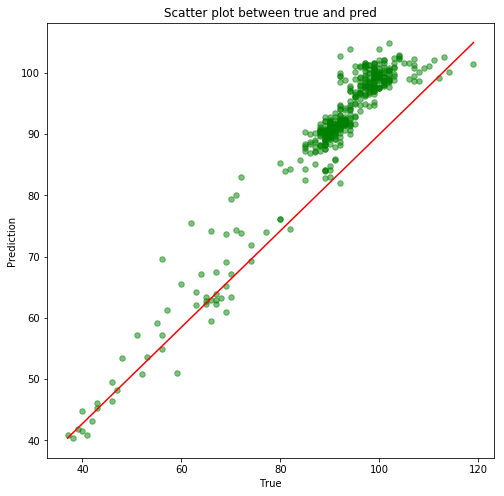

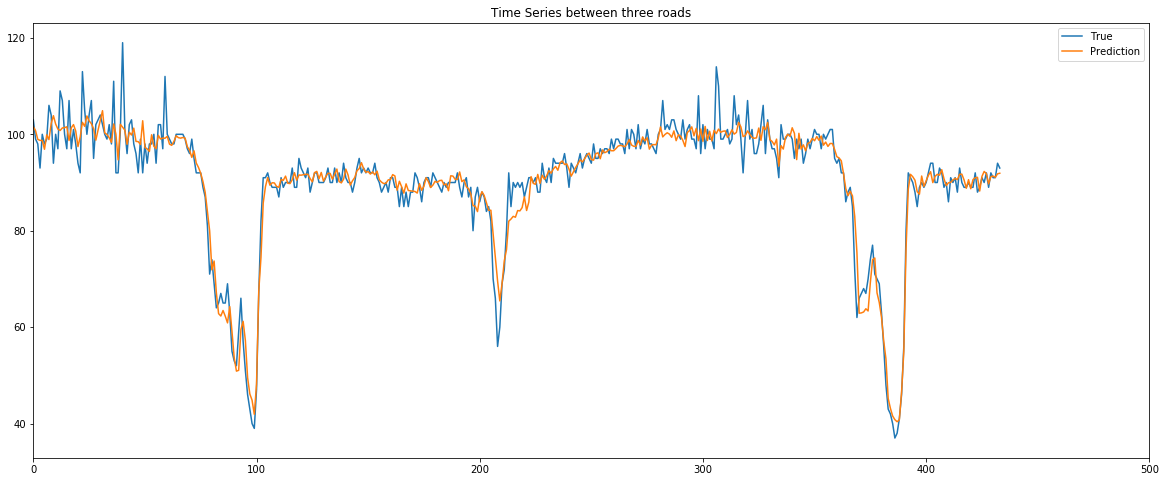

pred : [ 91.046]
true : [[91]]


In [21]:
stat = "01F0099S"
stat_next = "01F0147S" # 往哪個方向走
mon = 9
day = 8
hr = 12
mins = 40

# data collection
t, df_t, last_stat, next_stat = select_data(df, stat, stat_next, mon, day, hr, mins)
X, y, X_train, y_train, X_test, y_test, test, true = dataprepare(df_t, last_stat, next_stat)

# prediction
rfr = RandomForestRegressor(n_estimators=500, max_features=6)
prediction(rfr, X, y, X_train, y_train, X_test, y_test, test, true)


In [13]:
col = df.columns[:9]
def training(model, X_train, y_train):
    t0 = time.time()
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    t1 = time.time()
    print("training time %f sec" % (t1 - t0))
    print ("mean squared error :", (-1*sum(score)/10))
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(col)), model.feature_importances_)
    plt.xticks(np.arange(len(col)), col)
    plt.ylim(0, 0.6)
    plt.ylabel("feature_importances")
    plt.title("Feature Importances of Random Forest Regression")
    plt.show()
